In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [3]:
random_state = 0

# IMPORT DATASET

In [4]:
dataset_path = parentdir + "/datasets/HARDataset/"

In [5]:
dataset_name = "HARDataset"

In [6]:
X = pd.read_csv(dataset_path + "/train/" + "X_train.txt", header=None, delim_whitespace=True)

X = pd.DataFrame(X.values)

y = pd.read_csv(dataset_path + "/train/" + "y_train.txt", header = None, delim_whitespace=True).values
y_all = np.ravel(y).astype("int")
le = LabelEncoder()
le.fit(y_all)
y_all = le.transform(y_all)
#X["class"] = y
X_all = X.values.reshape((X.shape[0], X.shape[1], 1))

In [7]:
print("X SHAPE: ", X_all.shape)
print("y SHAPE: ", y_all.shape)
unique, counts = np.unique(y_all, return_counts=True)
print("\nCLASSES BALANCE")
for i, label in enumerate(unique):
    print(label, ": ", round(counts[i]/sum(counts), 2))

X SHAPE:  (7352, 561, 1)
y SHAPE:  (7352,)

CLASSES BALANCE
0 :  0.17
1 :  0.15
2 :  0.13
3 :  0.17
4 :  0.19
5 :  0.19


In [8]:
X_test = pd.read_csv(dataset_path + "/test/" + "X_test.txt", header=None, delim_whitespace=True)

X_test = pd.DataFrame(X_test.values)

y_test = pd.read_csv(dataset_path + "/test/" + "y_test.txt", header = None, delim_whitespace=True).values
y_test = np.ravel(y_test).astype("int")
y_test = le.transform(y_test)
#X["class"] = y
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

In [9]:
print("X SHAPE: ", X_test.shape)
print("y SHAPE: ", y_test.shape)

X SHAPE:  (2947, 561, 1)
y SHAPE:  (2947,)


## DATASET SPLIT

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# BLACKBOX/EXPLANATION SETS SPLIT
X_train, X_exp, y_train, y_exp = train_test_split(X_all, y_all, 
                                                  test_size=0.3, stratify = y_all, random_state=random_state)

# BLACKBOX TRAIN/VALIDATION SETS SPLIT
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, stratify = y_train, random_state=random_state)

# EXPLANATION TRAIN/TEST SETS SPLIT
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y_exp, 
                                                                    test_size=0.2, 
                                                                    stratify = y_exp, 
                                                                    random_state=random_state)

# EXPLANATION TRAIN/VALIDATION SETS SPLIT
X_exp_train, X_exp_val, y_exp_train, y_exp_val = train_test_split(X_exp_train, y_exp_train, 
                                                                  test_size=0.2, 
                                                                  stratify = y_exp_train, 
                                                                  random_state=random_state)

print("SHAPES:")
print("BLACKBOX TRAINING SET: ", X_train.shape)
print("BLACKBOX VALIDATION SET: ", X_val.shape)
print("BLACKBOX TEST SET: ", X_test.shape)
print("EXPLANATION TRAINING SET: ", X_exp_train.shape)
print("EXPLANATION VALIDATION SET: ", X_exp_val.shape)
print("EXPLANATION TEST SET: ", X_exp_test.shape)

SHAPES:
BLACKBOX TRAINING SET:  (4116, 561, 1)
BLACKBOX VALIDATION SET:  (1030, 561, 1)
BLACKBOX TEST SET:  (2947, 561, 1)
EXPLANATION TRAINING SET:  (1411, 561, 1)
EXPLANATION VALIDATION SET:  (353, 561, 1)
EXPLANATION TEST SET:  (442, 561, 1)


In [12]:
n_timesteps, n_outputs, n_features = X_train.shape[1], len(np.unique(y_all)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  561
N. LABELS:  6


# BLACKBOX MODEL

In [19]:
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import UpSampling1D
from keras import optimizers
from keras.models import Model
from keras import backend as K
from keras.layers import Dropout
from keras.layers import Reshape
from keras.utils import to_categorical
import time

In [20]:
from blackboxes import *

In [21]:
import blackboxes

In [22]:
import importlib
importlib.reload(blackboxes)

<module 'blackboxes' from '/Users/francesco/github/TS_AgnosticLocalExplainer/blackboxes.py'>

## resnet

In [23]:
blackbox = build_resnet(n_timesteps, n_outputs)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
file_path = parentdir + "/blackbox_checkpoints/" + dataset_name + "_blackbox_resnet_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_+{val_acc:.2f}_.hdf5")

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                   monitor='val_acc', 
                                                   save_weights_only = True, verbose = 1,
                                                   save_best_only=True)

callbacks = [reduce_lr, model_checkpoint]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [ ]:
blackbox.fit(X_train, y_train, epochs=20, batch_size=mini_batch_size, callbacks = callbacks,
             validation_data=(X_val, y_val))

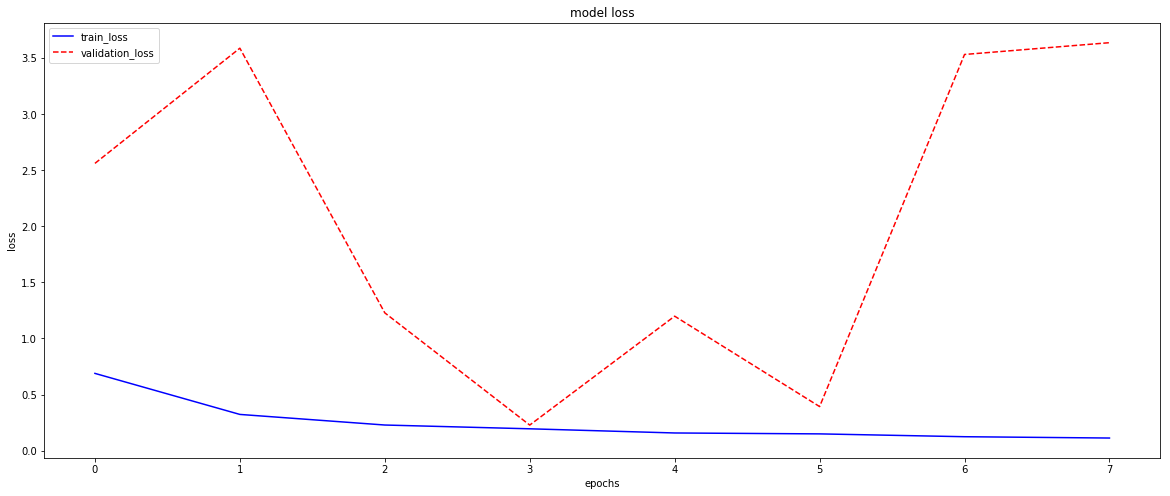

In [47]:
plt.figure(figsize=(20,8))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(blackbox.history.history["loss"], color = "blue", label = "train_loss")
plt.plot(blackbox.history.history["val_loss"], color = "red", linestyle = "dashed", label = "validation_loss")
plt.legend()

plt.show()

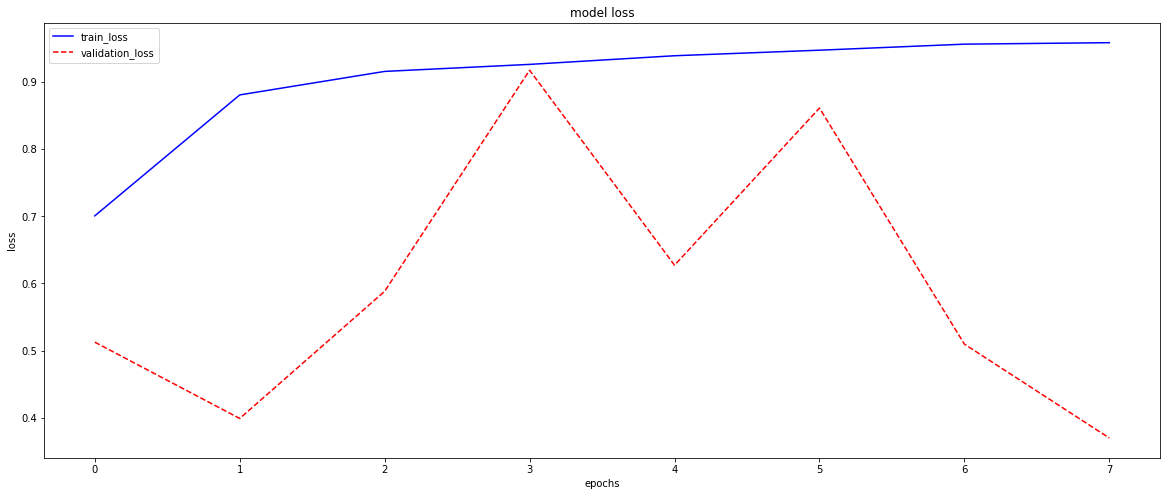

In [48]:
plt.figure(figsize=(20,8))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(blackbox.history.history["acc"], color = "blue", label = "train_loss")
plt.plot(blackbox.history.history["val_acc"], color = "red", linestyle = "dashed", label = "validation_loss")
plt.legend()

plt.show()

### load best weights

In [24]:
blackbox.load_weights(parentdir + "/blackbox_checkpoints/HARDataset_blackbox_resnet_20191028_172136_best_weights_+0.99_.hdf5")

In [37]:
blackbox.evaluate(X_test, y_test)

2947/2947 [==============================] - 32s 11ms/step


[0.266308270691011, 0.9246691550830684]

In [ ]:
resnet = blackbox

## simple CNN

In [574]:
blackbox = build_simple_CNN(n_timesteps, n_outputs)
blackbox.summary()
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
file_path = parentdir + "/blackbox_checkpoints/" + dataset_name + "_blackbox_simpleCNN_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_+{val_acc:.2f}_.hdf5")

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                   monitor='val_acc', 
                                                   save_weights_only = True, verbose = 1,
                                                   save_best_only=True)

callbacks = [reduce_lr, model_checkpoint]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_247 (Conv1D)          (None, 554, 16)           144       
_________________________________________________________________
batch_normalization_222 (Bat (None, 554, 16)           64        
_________________________________________________________________
activation_231 (Activation)  (None, 554, 16)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 554, 16)           0         
_________________________________________________________________
conv1d_248 (Conv1D)          (None, 550, 32)           2592      
_________________________________________________________________
batch_normalization_223 (Bat (None, 550, 32)           128       
_________________________________________________________________
activation_232 (Activation)  (None, 550, 32)          

In [114]:
blackbox.fit(X_train, y_train, epochs=20, batch_size=mini_batch_size, callbacks = callbacks,
             validation_data=(X_val, y_val))

Train on 4116 samples, validate on 1030 samples
Epoch 1/20
4116/4116 [==============================] - 15s 4ms/step - loss: 0.3113 - acc: 0.8783 - val_loss: 0.2573 - val_acc: 0.8990

Epoch 00001: val_acc did not improve from 0.90291
Epoch 2/20
4116/4116 [==============================] - 16s 4ms/step - loss: 0.3132 - acc: 0.8763 - val_loss: 0.2812 - val_acc: 0.8874

Epoch 00002: val_acc did not improve from 0.90291
Epoch 3/20
4116/4116 [==============================] - 16s 4ms/step - loss: 0.2968 - acc: 0.8863 - val_loss: 0.2901 - val_acc: 0.8903

Epoch 00003: val_acc did not improve from 0.90291
Epoch 4/20
4116/4116 [==============================] - 16s 4ms/step - loss: 0.2941 - acc: 0.8844 - val_loss: 0.2447 - val_acc: 0.9000

Epoch 00004: val_acc did not improve from 0.90291
Epoch 5/20
4116/4116 [==============================] - 19s 5ms/step - loss: 0.2909 - acc: 0.8912 - val_loss: 0.2459 - val_acc: 0.9029

Epoch 00005: val_acc did not improve from 0.90291
Epoch 6/20
4116/4116 [

### load best weights

In [575]:
blackbox.load_weights(parentdir + "/blackbox_checkpoints/HARDataset_blackbox_simpleCNN_20191029_153407_best_weights_+0.94_.hdf5")

In [576]:
blackbox.evaluate(X_test, y_test)

2947/2947 [==============================] - 6s 2ms/step


[0.2654894328027367, 0.8910756701831701]

In [ ]:
simplecnn = blackbox

## KNN

In [577]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

### grid search

In [77]:
#metriche usate nella grid search
scoring = {'MSE':make_scorer(mean_squared_error, greater_is_better=False), 'Accuracy': make_scorer(accuracy_score)}

#iperparametri
n_neighbors = list(range(1, 100))
metric = ["euclidean", "manhattan"]
#weights = ['uniform', 'distance']
weights = ['distance']
param_grid = dict(n_neighbors = n_neighbors, weights = weights, metric = metric)

#Definition of algorithm and GridSearch
knn = KNeighborsClassifier(algorithm='auto')
cv = StratifiedKFold(random_state=random_state, n_splits=3)
grid = GridSearchCV(knn, param_grid = param_grid, cv = cv, scoring = scoring, n_jobs=-1, 
                    return_train_score=True, refit='MSE', verbose=1)

In [78]:
%%time
grid.fit(X_train.reshape(X_train.shape[:2]), y_train)
results = grid.cv_results_

Fitting 3 folds for each of 198 candidates, totalling 594 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 67.1min


CPU times: user 2.34 s, sys: 364 ms, total: 2.7 s
Wall time: 1h 28min 32s


[Parallel(n_jobs=-1)]: Done 594 out of 594 | elapsed: 88.5min finished


In [79]:
grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}

In [87]:
df_results = pd.DataFrame(results)

In [88]:
df_results.at[grid.best_index_, 'mean_test_Accuracy']

0.9686588921282799

In [90]:
# creo un datframe per ogni misura di distanza
df_results = df_results.sort_index()
df_per_metric = []
for distance in metric:
    df_per_metric.append(df_results[df_results["param_metric"] == distance])  

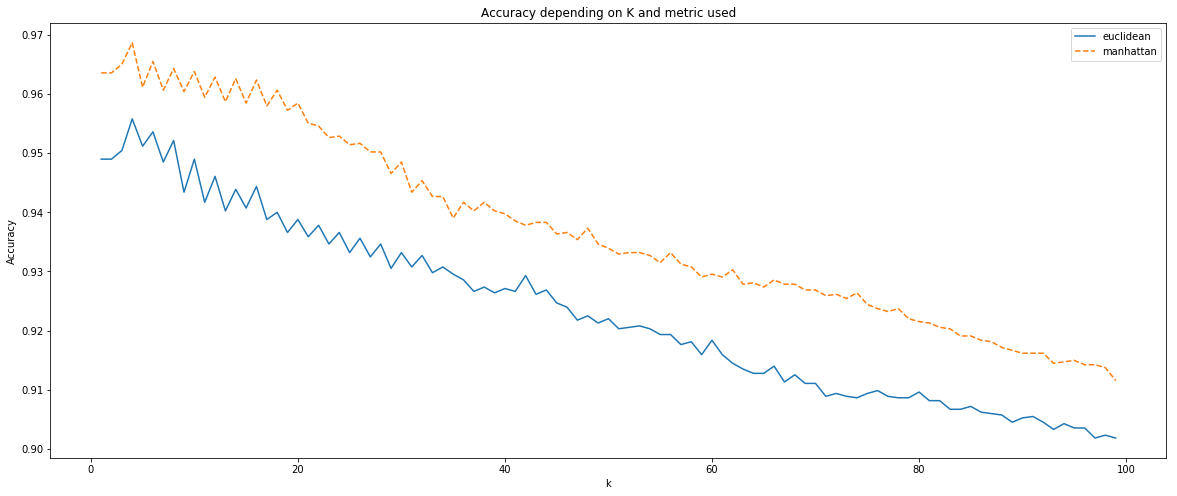

In [92]:
plt.figure(figsize=(20,8))
plt.title('Accuracy depending on K and metric used')
plt.ylabel('Accuracy')
plt.xlabel('k')
linestyles = ['-', '--', '-.', ':']

for i in range(len(df_per_metric)):
    plt.plot(df_per_metric[i]["param_n_neighbors"], df_per_metric[i]["mean_test_Accuracy"], linestyle = linestyles[i], label = metric[i])

plt.legend()
plt.show()

In [99]:
#salva la tabella dei risultati con data + parametri migliori
#chiede da solo in input da tastiera il nome del dataset da usare all'inizio del nome del file

date = time.strftime("%Y%m%d_%H%M%S")
parameter_string = ""
for key in grid.best_params_:
    parameter_name = key
    best = str(grid.best_params_[key])
    parameter_string += parameter_name + "[" + best + "]" + "__"
#to_csv("avg_df_{}.csv".format(date), sep = ";", index = False)
filename = date + "__" + parameter_string
df_results.to_csv(parentdir + "/gridsearches/{}__{}.csv".format(dataset_name, filename), sep = ";", index = False)

### save knn with best params

In [ ]:
knn = KNeighborsClassifier(**grid.best_params_)

In [589]:
knn.fit(X_train.reshape(X_train.shape[:2]), y_train)

'knn.fit(X_train.reshape(X_train.shape[:2]), y_train)'

In [ ]:
path = parentdir + "/blackbox_checkpoints/" + dataset_name + "_blackbox_knn_" + (
    time.strftime("%Y%m%d_%H%M%S") + ".joblib")
dump(knn, path) 

### load best knn

In [588]:
knn = load(parentdir + "/blackbox_checkpoints/HARDataset_blackbox_knn_20191031_111540.joblib")

In [590]:
knn.score(X_test.reshape(X_test.shape[:2]), y_test)

0.9009161859518154

In [591]:
mean_squared_error(y_test, knn.predict(X_test.reshape(X_test.shape[:2])))

0.14591109602986088

# AUTOENCODER TRAINING

In [69]:
# TENSORBOARD
# tensorboard --logdir=/tmp/autoencoder
# http://0.0.0.0:6006
# lsof -i tcp:6006 | grep -v PID | awk '{print $2}' | xargs kill

In [13]:
import autoencoders
from autoencoders import *
import importlib
importlib.reload(autoencoders)

Using TensorFlow backend.


<module 'autoencoders' from '/Users/francesco/github/TS_AgnosticLocalExplainer/autoencoders.py'>

## Standard

In [39]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 50,
          "encoder_latent_layer_type": "dense",
          "encoder_args": {"filters":[2,4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"selu", 
                            "pooling":[1,1,1,1,1,1,1,1]}
         }

aut = Autoencoder(**params)
encoder, decoder, autoencoder = aut.build()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 561, 1)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 561, 2)            44        
_________________________________________________________________
batch_normalization_13 (Batc (None, 561, 2)            8         
_________________________________________________________________
activation_10 (Activation)   (None, 561, 2)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 561, 2)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 561, 4)            148       
______________________________

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 561, 1)            0         
_________________________________________________________________
Encoder (Model)              (None, 50)                194517    
_________________________________________________________________
Decoder (Model)              (None, 561, 1)            293156    
Total params: 487,673
Trainable params: 485,633
Non-trainable params: 2,040
_________________________________________________________________
None


In [520]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)

file_path = parentdir + "/autoencoder_checkpoints/" + dataset_name + "_autoencoder_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_+{val_loss:.4f}_.hdf5")

to_dict = open(parentdir + "/autoencoder_checkpoints/" + dataset_name + "_autoencoder_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_.txt"),"w")
to_dict.write( str(params) )
to_dict.close()

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                   monitor='val_loss', 
                                                   save_weights_only = True, verbose = 1,
                                                   save_best_only=True)
callbacks = [reduce_lr,model_checkpoint]


In [521]:
history = autoencoder.fit(X_exp_train, X_exp_train, epochs=50, validation_data=(X_exp_val, X_exp_val), verbose = 1, 
                callbacks = callbacks)

Train on 1411 samples, validate on 353 samples
Epoch 1/50
1411/1411 [==============================] - 30s 21ms/step - loss: 140.7334 - mean_squared_error: 0.2205 - val_loss: 84.6674 - val_mean_squared_error: 0.1325

Epoch 00001: val_loss improved from inf to 84.66741, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+84.6674_.hdf5
Epoch 2/50
1411/1411 [==============================] - 15s 11ms/step - loss: 59.4241 - mean_squared_error: 0.0981 - val_loss: 60.8427 - val_mean_squared_error: 0.0979

Epoch 00002: val_loss improved from 84.66741 to 60.84270, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+60.8427_.hdf5
Epoch 3/50
1411/1411 [==============================] - 16s 11ms/step - loss: 47.7815 - mean_squared_error: 0.0806 - val_loss: 50.8042 - val_mean_squared_error: 0.0836

Epoch 00003: val_loss improved from 60.84270 to 50.80422, saving model to ./autoencoder_checkpoints/HARDataset_autoe

1411/1411 [==============================] - 15s 10ms/step - loss: 18.1802 - mean_squared_error: 0.0320 - val_loss: 24.7901 - val_mean_squared_error: 0.0438

Epoch 00028: val_loss did not improve from 22.70151
Epoch 29/50
1411/1411 [==============================] - 14s 10ms/step - loss: 18.0126 - mean_squared_error: 0.0317 - val_loss: 24.4812 - val_mean_squared_error: 0.0432

Epoch 00029: val_loss did not improve from 22.70151
Epoch 30/50
1411/1411 [==============================] - 15s 10ms/step - loss: 17.8177 - mean_squared_error: 0.0313 - val_loss: 22.4595 - val_mean_squared_error: 0.0396

Epoch 00030: val_loss improved from 22.70151 to 22.45953, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+22.4595_.hdf5
Epoch 31/50
1411/1411 [==============================] - 14s 10ms/step - loss: 17.0562 - mean_squared_error: 0.0300 - val_loss: 21.3380 - val_mean_squared_error: 0.0376

Epoch 00031: val_loss improved from 22.45953 to 21.33802, sav

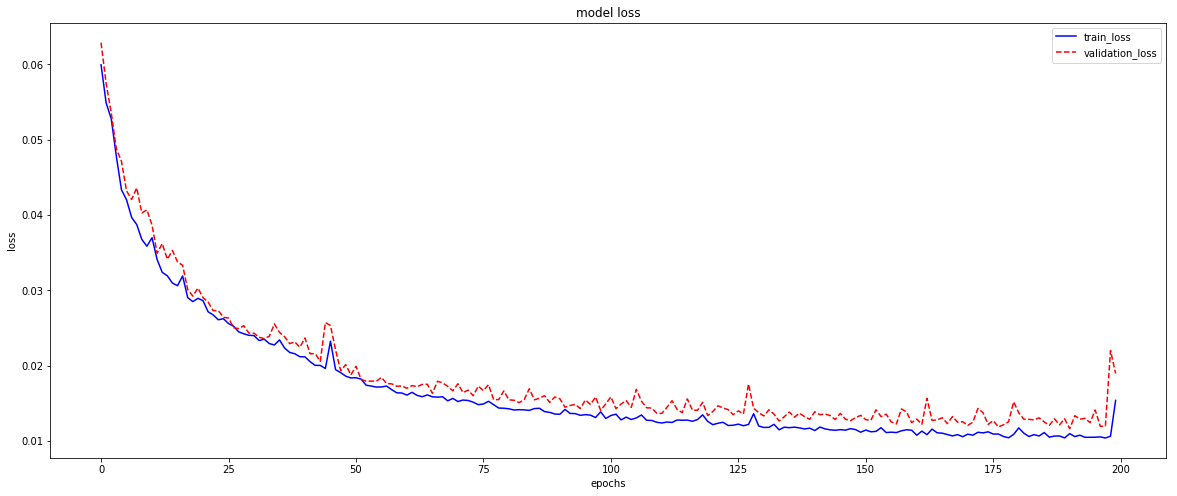

In [207]:
plt.figure(figsize=(20,8))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(history.history["loss"], color = "blue", label = "train_loss")
plt.plot(history.history["val_loss"], color = "red", linestyle = "dashed", label = "validation_loss")
plt.legend()

plt.show()

In [40]:
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/HARDataset_autoencoder_20191031_212226_best_weights_+0.008519_.hdf5")

In [41]:
autoencoder.evaluate(X_exp_val, X_exp_val)

353/353 [==============================] - 6s 18ms/step


0.008519300130372682

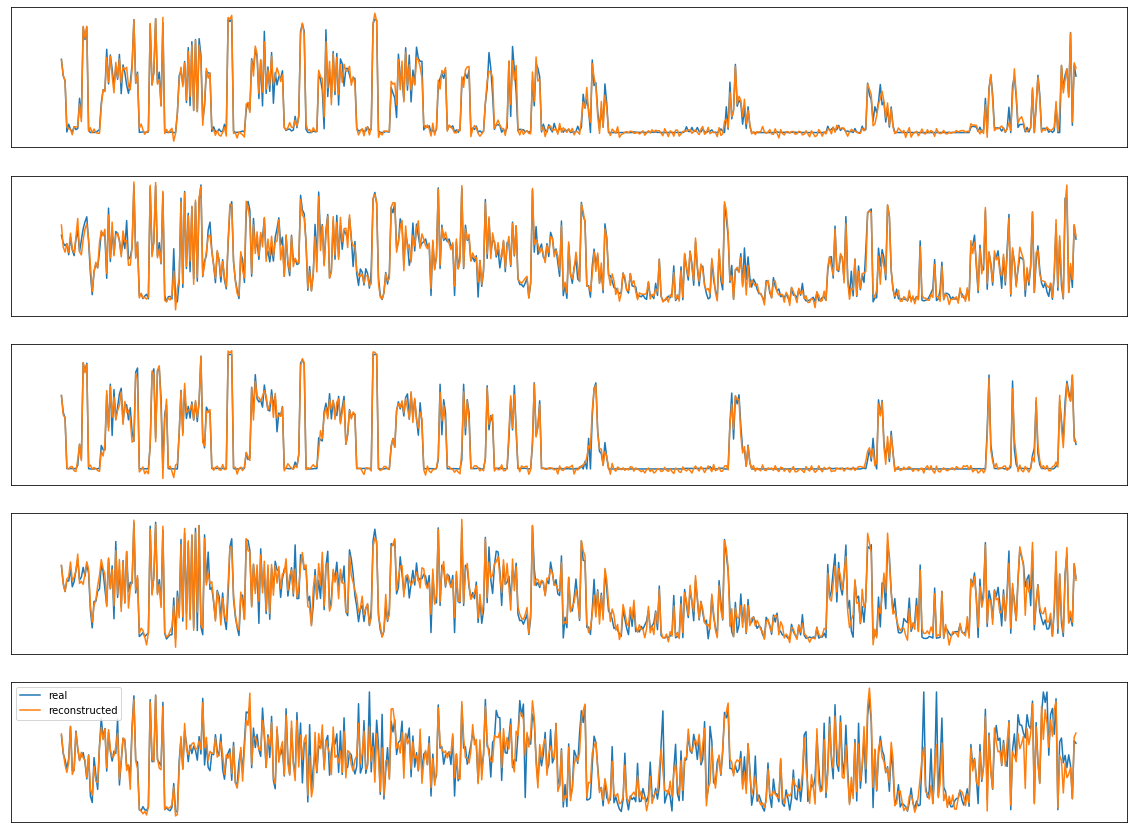

In [42]:
decoded_tss = autoencoder.predict(X_exp_val)
n = 100
g = 1
plt.figure(figsize=(20, 15))
for i in range(n, n+5):
    # display original
    ax = plt.subplot(5, 1, g)
    g  += 1
    plt.plot(X_exp_val[i], label = "real")
    plt.plot(decoded_tss[i], label = "reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.legend()
plt.show()

## VARIATIONAL

In [14]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 50,
          "encoder_latent_layer_type": "variational",
          "encoder_args": {"filters":[2,4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"selu", 
                            "pooling":[1,1,1,1,1,1,1,1]}
         }

aut = Autoencoder(**params)
encoder, decoder, autoencoder = aut.build()





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "VariationalEncoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 561, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 561, 2)       44          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 561, 2)       8           conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 561, 2)       0           batch_normaliza

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 561)               28611     
_________________________________________________________________
reshape_1 (Reshape)          (None, 561, 1)            0         
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 561, 1)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 561, 256)          1024      
_________________________________________________________________
batch_normalization_9 (Batch (None, 561, 256)          1024      
_________________________________________________________________
activation_10 (Activation)   (None, 561, 256)          0   

In [520]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)

file_path = parentdir + "/autoencoder_checkpoints/" + dataset_name + "_autoencoder_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_+{val_loss:.4f}_.hdf5")

to_dict = open(parentdir + "/autoencoder_checkpoints/" + dataset_name + "_autoencoder_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_.txt"),"w")
to_dict.write( str(params) )
to_dict.close()

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                   monitor='val_loss', 
                                                   save_weights_only = True, verbose = 1,
                                                   save_best_only=True)
callbacks = [reduce_lr,model_checkpoint]


In [521]:
history = autoencoder.fit(X_exp_train, X_exp_train, epochs=50, validation_data=(X_exp_val, X_exp_val), verbose = 1, 
                callbacks = callbacks)

Train on 1411 samples, validate on 353 samples
Epoch 1/50
1411/1411 [==============================] - 30s 21ms/step - loss: 140.7334 - mean_squared_error: 0.2205 - val_loss: 84.6674 - val_mean_squared_error: 0.1325

Epoch 00001: val_loss improved from inf to 84.66741, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+84.6674_.hdf5
Epoch 2/50
1411/1411 [==============================] - 15s 11ms/step - loss: 59.4241 - mean_squared_error: 0.0981 - val_loss: 60.8427 - val_mean_squared_error: 0.0979

Epoch 00002: val_loss improved from 84.66741 to 60.84270, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+60.8427_.hdf5
Epoch 3/50
1411/1411 [==============================] - 16s 11ms/step - loss: 47.7815 - mean_squared_error: 0.0806 - val_loss: 50.8042 - val_mean_squared_error: 0.0836

Epoch 00003: val_loss improved from 60.84270 to 50.80422, saving model to ./autoencoder_checkpoints/HARDataset_autoe

1411/1411 [==============================] - 15s 10ms/step - loss: 18.1802 - mean_squared_error: 0.0320 - val_loss: 24.7901 - val_mean_squared_error: 0.0438

Epoch 00028: val_loss did not improve from 22.70151
Epoch 29/50
1411/1411 [==============================] - 14s 10ms/step - loss: 18.0126 - mean_squared_error: 0.0317 - val_loss: 24.4812 - val_mean_squared_error: 0.0432

Epoch 00029: val_loss did not improve from 22.70151
Epoch 30/50
1411/1411 [==============================] - 15s 10ms/step - loss: 17.8177 - mean_squared_error: 0.0313 - val_loss: 22.4595 - val_mean_squared_error: 0.0396

Epoch 00030: val_loss improved from 22.70151 to 22.45953, saving model to ./autoencoder_checkpoints/HARDataset_autoencoder_20191030_183019_best_weights_+22.4595_.hdf5
Epoch 31/50
1411/1411 [==============================] - 14s 10ms/step - loss: 17.0562 - mean_squared_error: 0.0300 - val_loss: 21.3380 - val_mean_squared_error: 0.0376

Epoch 00031: val_loss improved from 22.45953 to 21.33802, sav

In [ ]:
plt.figure(figsize=(20,8))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(history.history["loss"], color = "blue", label = "train_loss")
plt.plot(history.history["val_loss"], color = "red", linestyle = "dashed", label = "validation_loss")
plt.legend()

plt.show()

In [15]:
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/HARDataset_autoencoder_20191201_153104_best_weights_+17.406494_.hdf5")

In [16]:
autoencoder.evaluate(X_exp_val, X_exp_val)

353/353 [==============================] - 11s 31ms/step


[17.74246604314269, 0.024360951125917286]

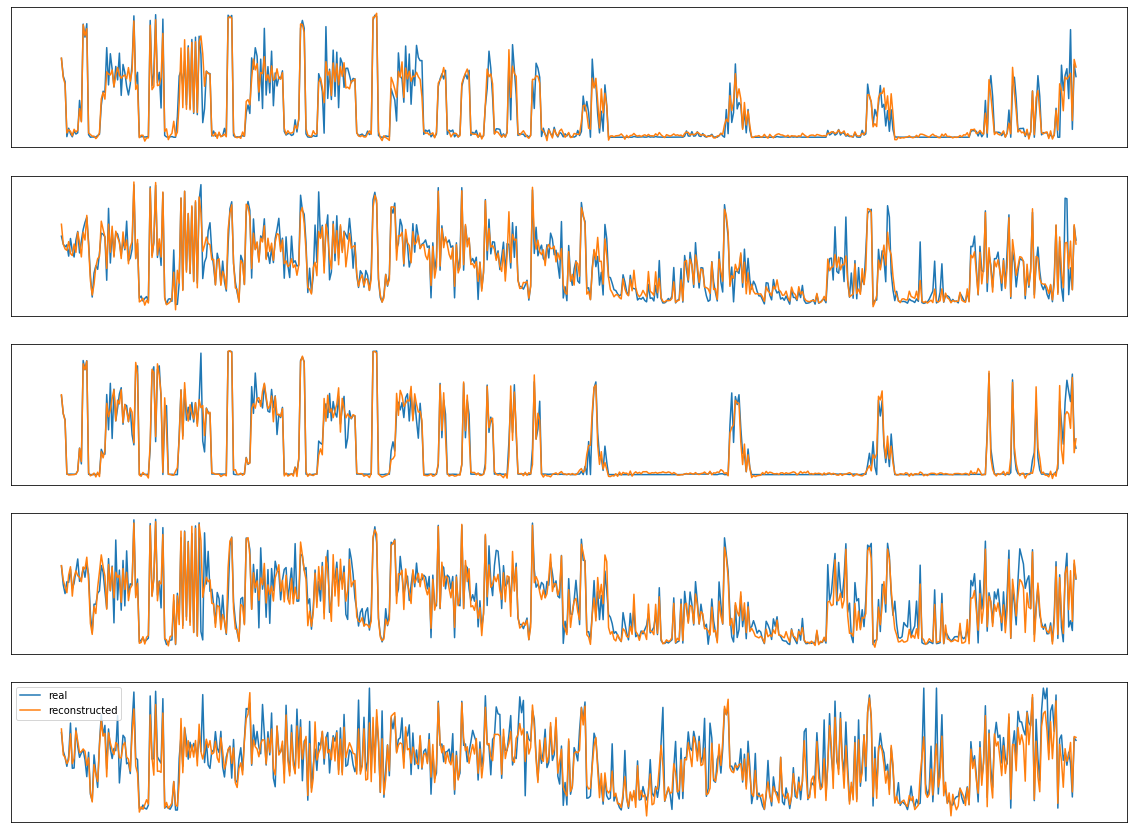

In [17]:
decoded_tss = autoencoder.predict(X_exp_val)
n = 100
g = 1
plt.figure(figsize=(20, 15))
for i in range(n, n+5):
    # display original
    ax = plt.subplot(5, 1, g)
    g  += 1
    plt.plot(X_exp_val[i], label = "real")
    plt.plot(decoded_tss[i], label = "reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.legend()
plt.show()

## Standard (LSTM)

In [29]:
from toy_autoencoders import build_lstm_autoencoder
from myutils import reconstruction_blackbox_consistency

In [25]:
autoencoder = build_lstm_autoencoder(n_timesteps, 50)

In [ ]:
file_path = parentdir + "/autoencoder_checkpoints/" + dataset_name + "_lstm_autoencoder_" + (time.strftime("%Y%m%d_%H%M%S") + "_best_weights_+{val_loss:.6f}_.hdf5")

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                  monitor='val_loss', 
                                                  save_weights_only = True, verbose = 1,
                                                  save_best_only=True)
callbacks = [model_checkpoint]

In [ ]:
history = model.fit(X_exp_train, X_exp_train, epochs=200, validation_data=(X_exp_val, X_exp_val), verbose = 1, callbacks = callbacks)

In [ ]:
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/HARDataset_lstm_autoencoder_20191130_093909_best_weights_+0.070170_.hdf5")

In [31]:
reconstruction_blackbox_consistency(autoencoder, blackbox, X_exp_test)

0.33710407239819007

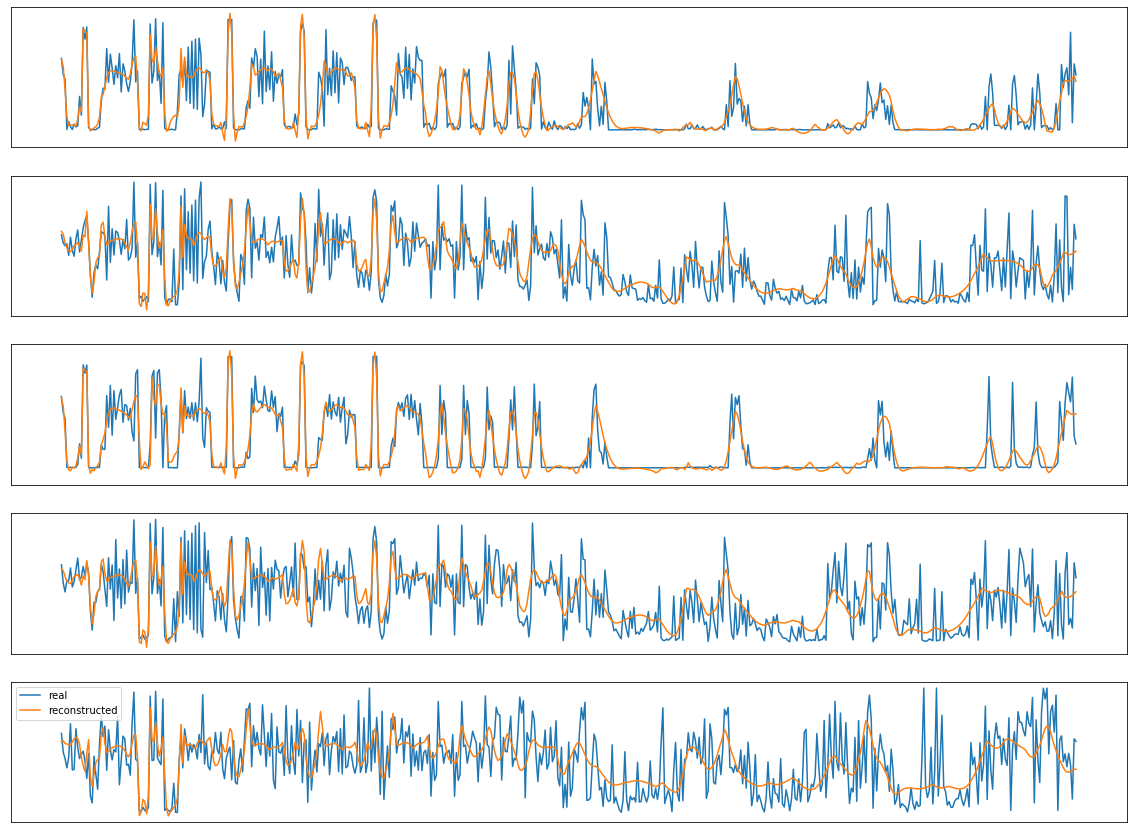

In [32]:
decoded_tss = autoencoder.predict(X_exp_val)
n = 100
g = 1
plt.figure(figsize=(20, 15))
for i in range(n, n+5):
    # display original
    ax = plt.subplot(5, 1, g)
    g  += 1
    plt.plot(X_exp_val[i], label = "real")
    plt.plot(decoded_tss[i], label = "reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.legend()
plt.show()